# 03-Stumps, trees and forests

** Ecole Centrale Nantes **

** Diana Mateus **

PARTICIPANTS: **Yassine Jamoud and Samy Haffoudhi**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## 1. Decision stumps
A decision stump is a machine learning model consisting of a one-level decision tree. That is, it is a decision tree with one internal node (the root) which is immediately connected to the terminal nodes (its leaves). A decision stump makes a prediction based on the value of just a single input feature. Sometimes they are also called 1-rules [Wikipedia]

***a)*** Run the provided code to generate and plot a toy dataset consisting of 2D points and 4 classes



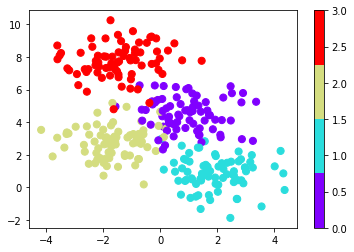

In [2]:
#a) Load and plot dataset, split in train and test sets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

n_classes = 4
X, y = make_blobs(n_samples=300, centers=n_classes,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=plt.cm.get_cmap('rainbow', 4));
plt.colorbar();

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)




**b)** Observe the functions **stump** and **split**. 

**stump** is a function that generates the parameters of a random axis-aligned split  according to the number of features of a given dataset. The function receives the data matrix Xtrain and returns
    - the index of one randomly chosen feature (one dimension) 
    - as well as a randomly chosen threshold within the min and max values of the chosen feature.

**split**  receives as input:
    - A dataset of points
    - the parameters generated by the stump function above. 
The function then partitions the *dataset* in two subsets according to the threshold of the chosen dimension.
The output are two arrays, each containing the _indices_ of the points belonging to one or the other subset. 

**c)** Run the split function **several times**, and display the resulting subsets as 2D scatter plots with circles of different colors for each class. Use the provided plotting functions.

Stump parameters 1 5.712740684026194
Sizes: original set: 225  left subset: (162,)  right subset: (63,)
Stump parameters 1 8.287820453215875
Sizes: original set: 225  left subset: (209,)  right subset: (16,)
Stump parameters 1 6.362395221042126
Sizes: original set: 225  left subset: (173,)  right subset: (52,)
Stump parameters 0 -3.127501594838785
Sizes: original set: 225  left subset: (11,)  right subset: (214,)
Stump parameters 0 0.7071947646065775
Sizes: original set: 225  left subset: (141,)  right subset: (84,)


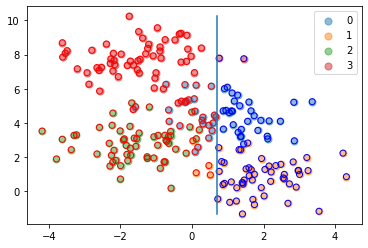

In [3]:
from random import randint, uniform

# b) Stumps and Split

def stump(X):
    f = randint(0, X.shape[1]-1) #randomly select a feature/dimension randint()
    t = uniform(np.min(X[:,f]),np.max(X[:,f])) #sample from an uniform() between the min and max values of the feature
    return f,t 


def split(X, f, t):
    ind_l, = np.where(X[:,f]<=t)
    ind_r, = np.where(X[:,f]>t)
    return ind_l, ind_r

# c) Plotting a stump

def plot_stump (Xtrain,ytrain,feat,th,ind_l,ind_r):
    n_classes=np.max(ytrain)+1;
    #print(n_classes)
    for c in range(n_classes):
        X0_c=Xtrain[np.where(ytrain==c), 0] #first coordinate of points belonging to class c
        X1_c=Xtrain[np.where(ytrain==c), 1] #second coordinate of points belonging to class c
        plt.scatter(X0_c,X1_c, s=50,alpha=0.5,cmap=plt.cm.get_cmap('rainbow', 4),label=str(c))

    #plt.axis('equal')

    #draw the points on the left and right child as circles around the original training dataset
    plt.scatter(Xtrain[ind_l, 0], Xtrain[ind_l, 1], c='none', edgecolor='r')
    plt.scatter(Xtrain[ind_r, 0], Xtrain[ind_r, 1], c='none', edgecolor='b')

    #draw threshold line
    if feat == 0:
        plt.plot([th,th],[np.min(Xtrain[:,1]),np.max(Xtrain[:,1])])
    elif feat == 1:
        plt.plot([np.min(Xtrain[:,0]),np.max(Xtrain[:,0])],[th,th])
    leg = plt.legend();

n_stumps = 5
for _ in range(n_stumps):
    feat, th = stump(Xtrain)
    print('Stump parameters', feat, th)
    ind_l,ind_r = split(Xtrain, feat, th)
    print('Sizes: original set:', len(ytrain), 
          ' left subset:' ,  ind_l.shape,
          ' right subset:', ind_r.shape)

plot_stump(Xtrain,ytrain,feat,th,ind_l,ind_r)


**d)** Implement a function ***class_distributions*** that given a set of points reaching a node returns the posterior class distribution of the node (approximated as the normalized histogram with #points per class).

``` python
def class_distributions(ytrain,ind_left, ind_right):
```

Compute the class distributions of:
    - of the original training set (before the split), 
    - of each of the 2 subsets resulting from after the split has been applied.

Plot the histograms of the children nodes

**e)** Create a function to compute the ***information_gain*** of a split. The function should receive the full training dataset (Xtrain and ytrain) and the indices of two subsets resulting from the current split. 

``` python
def information_gain(ytrain,ind_left, ind_right):
```
```Hint: ```  when computing the Entropy, ignore the classes with zero probabilities, and carry on summation using the same equation.


In [4]:
def class_distributions(ytrain, ind_left, ind_right):
    left_distribution=[len(np.where(ytrain[ind_left]==i)[0]) for i in range(4)]
    right_distribution=[len(np.where(ytrain[ind_right]==i)[0]) for i in range(4)]
    return left_distribution, right_distribution

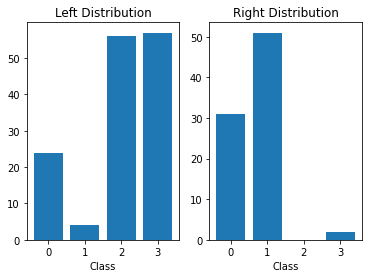

In [5]:
left_distribution, right_distribution = class_distributions(ytrain,ind_l,ind_r)
plt.subplot(1,2,1)
plt.bar(range(4), left_distribution)
plt.xlabel('Class')
plt.title('Left Distribution')
plt.subplot(1,2,2)
plt.bar(range(4), right_distribution)
plt.xlabel('Class')
plt.title('Right Distribution')

plt.show()

In [6]:
def entropy(y):
    return -sum([(y == i).sum() / len(y) * np.log2((y == i).sum() / len(y)) for i in range(np.max(ytrain)+1) if (y == i).sum() > 0])

def information_gain(ytrain, ind_left, ind_right):
    return entropy(ytrain) - (len(ind_left) / len(ytrain)) * entropy(ytrain[ind_left]) - (len(ind_right) / len(ytrain)) * entropy(ytrain[ind_right]) 
               
# information_gain(ytrain, ind_l, ind_r)

**f)** Create a function ***train*** to perfom a *randomized node optimization*. The function receives as parameters the full training dataset (Xtrain and ytrain) as well as the number of random stumps to try. The function will 
- generate the desired number of stumps, 
- split the dataset according to each stump, 
- evaluate the ***information gain*** for each split
- choose and then return the parameters of the best stump.

``` python
def train_stumps(Xtrain, ytrain, trials):
```

Print the progress of the information gain during the training process

**g)** Make predictions with the trained model and display the restuls

In [7]:
def train_stumps(Xtrain, ytrain, trials):
    best_information_gain = float('-inf')
    for _ in range(trials):
        f, t = stump(Xtrain)
        ind_l, ind_r = split(Xtrain, f, t)

        curr = information_gain(ytrain, ind_l, ind_r)
        if curr > best_information_gain:
            best_information_gain = curr
            f_best, t_best = f, t
            
    return f_best, t_best

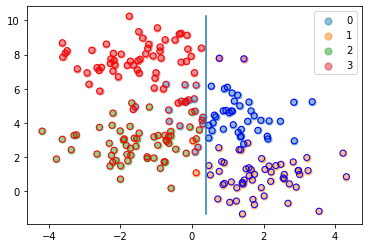

In [8]:
f, t = train_stumps(Xtrain, ytrain, 100)
ind_l, ind_r = split(Xtrain, f, t)
plot_stump (Xtrain,ytrain,f,t,ind_l,ind_r)

## 3. Comparing classifiers on the Caltech 101 dataset

Compare the performances of an SVM, a Decision Tree and Random Forest classifiers on the **Caltech 101** dataset for a binary classification task (e.g. dragonfly vs crayfish)


**a)** Load and split the dataset into train and test with 75% and 25% respective proportions

**b)** Train three classification models on the train dataset 
- an SVM
- a single decision tree ``sklearn.tree.DecisionTree``
- a Random Forest ``sklearn.ensemble.RandomForestClassifier``

Print the accuracy on the train and test sets for each model. ``from sklearn import metrics``

**c)** Plot the roc curves for each model, and compute the areas under the curve

**d)** Do a gridsearch with a 5-fold crossvalidation varying the hyperparameters of each model (e.g., for the SVM the ``kernel``, the ``gamma`` and ``c``, and for the tree-based models  ``max_depth``, ``max_features``, ``min_samples_leaf``, and ``n_estimators``).

``from sklearn.model_selection import GridSearchCV``

**Hint**
```
tuned_parameters = [{'max_depth': [1, 5, 10], 
                     'max_features': [1, 15, 30, 45, 60],
                     'n_estimators': [1, 25, 50, 75, 100],
                     'min_samples_leaf': [3,5,10]}]
                     
```
- What are the best parameters found to maximize the area under the curve in each case?

**e)** Discuss the results and curves.

In [9]:
import os
import skimage

IMDIR = '101_ObjectCategories/'

labelNamesAll = []

for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)

labelNamesAll = labelNamesAll[0]
print(labelNamesAll)

['soccer_ball', 'sunflower', 'lamp', 'wrench', 'inline_skate', 'euphonium', 'car_side', 'chandelier', 'watch', 'pigeon', 'laptop', 'dolphin', 'okapi', 'electric_guitar', 'cup', 'helicopter', 'accordion', 'crab', 'metronome', 'Motorbikes', 'gramophone', 'brain', 'windsor_chair', 'dalmatian', 'wheelchair', 'water_lilly', 'stop_sign', 'crocodile_head', 'hedgehog', 'brontosaurus', 'flamingo_head', 'anchor', 'tick', 'crocodile', 'pyramid', 'Faces_easy', 'mayfly', 'ewer', 'hawksbill', 'rooster', 'BACKGROUND_Google', 'joshua_tree', 'headphone', 'scissors', 'octopus', 'stapler', 'revolver', 'llama', 'lotus', 'beaver', 'airplanes', 'bonsai', 'platypus', 'bass', 'cougar_face', 'pagoda', 'dragonfly', 'trilobite', 'garfield', 'gerenuk', 'rhino', 'cellphone', 'elephant', 'ant', 'saxophone', 'camera', 'binocular', 'yin_yang', 'sea_horse', 'Leopards', 'kangaroo', 'cougar_body', 'cannon', 'ferry', 'ceiling_fan', 'menorah', 'butterfly', 'minaret', 'Faces', 'emu', 'ketch', 'snoopy', 'starfish', 'nautilu

In [10]:
imWidth = 100
imHeight = 100
N = 100

X = np.zeros([2*N,imHeight*imWidth])
Y = -np.ones([2*N,1])
labelNames = ['dragonfly', 'crayfish']

globalCount = 0
for (i, label) in enumerate(labelNames):
    filedir = os.path.join(IMDIR,label)

    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith('.jpg') and globalCount <= N:
            image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')
            X[globalCount,:] = image.flatten()
            Y[globalCount,:] = i
            globalCount += 1

print("Total number of samples",globalCount)
X = X[:globalCount,:]
Y = Y[:globalCount,:]

#Check the stored classes
print("used labels",labelNames)
print("Size of data matrix", X.shape)
print("clas labels", Y.T)

Total number of samples 101
used labels ['dragonfly', 'crayfish']
Size of data matrix (101, 10000)
clas labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]]


In [11]:
from sklearn.utils import shuffle

Ntrain = np.rint(.75*Y.shape[0]).astype(int)
Ntest = Y.shape[0]-Ntrain
print('Training with', Ntrain , 'training samples and ', Ntest, 'testing samples.')

# Randomize the order of X and Y
X, Y = shuffle(X, Y, random_state=0)

# Split the data and labels into training/testing sets
X_train = X[0:Ntrain,:]
Y_train = Y[0:Ntrain,:]

X_test = X[Ntrain:,:]
Y_test = Y[Ntrain:,:]

print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)

Training with 76 training samples and  25 testing samples.
size of train dataset (76, 10000)
size of test dataset (25, 10000)
train target vector [[0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
  0. 1. 1. 1.]]
test target vector [[0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.
  0.]]


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clfs = {
    "SVM": SVC(random_state=42), 
    "Decision Tree": DecisionTreeClassifier(random_state=42), 
    "Random Forest": RandomForestClassifier(random_state=42)
}

for (name, clf) in clfs.items():
    print(name)
    clf.fit(X_train, Y_train.ravel())

    Y_pred = clf.predict(X_train)
    print("Training accuray:", accuracy_score(Y_train.ravel(), Y_pred))

    Y_pred = clf.predict(X_test)
    print("Testing accuracy:", accuracy_score(Y_test.ravel(), Y_pred))

SVM
Training accuray: 0.9078947368421053
Testing accuracy: 0.64
Decision Tree
Training accuray: 1.0
Testing accuracy: 0.72
Random Forest
Training accuray: 1.0
Testing accuracy: 0.68


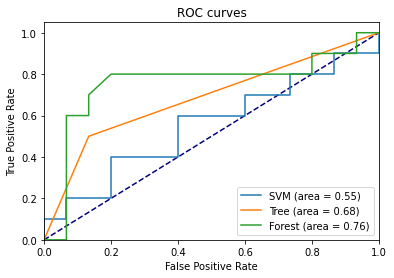

In [13]:
from sklearn.metrics import roc_curve, auc

Y_score = clfs['SVM'].decision_function(X_test)

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.plot(fpr, tpr, label="SVM (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Y_score = clfs['Decision Tree'].predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="Tree (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Y_score = clfs['Random Forest'].predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="Forest (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curves')

plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV

C_range = np.logspace(-12,3,16)
gamma_range = np.logspace(-12,0,13)

parametres = {'C': C_range, 'gamma': gamma_range,'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

grid = GridSearchCV(SVC(random_state=42), parametres, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, Y_train.ravel())

print(grid.best_params_)

clf_svm = grid.best_estimator_
clf_svm.fit(X_train, Y_train.ravel())

{'C': 1e-10, 'gamma': 1e-09, 'kernel': 'rbf'}


SVC(C=1e-10, gamma=1e-09, random_state=42)

In [22]:
parameters = {'max_depth': [3, 5, 10, 15], 
              'max_features': [1, 10, 100, 1000, 10000],
              'min_samples_leaf': [3, 5, 10, 15]}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, Y_train.ravel())

print(grid.best_params_)

clf_tree = grid.best_estimator_
clf_tree.fit(X_train, Y_train.ravel())

{'max_depth': 3, 'max_features': 1000, 'min_samples_leaf': 5}


DecisionTreeClassifier(max_depth=3, max_features=1000, min_samples_leaf=5,
                       random_state=42)

In [32]:
parameters = {'max_depth': [2, 3, 5, 10], 
              'max_features': [50, 100, 200],
              'n_estimators': [10, 30, 50, 70],
              'min_samples_leaf': [3, 5, 7]}

grid = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, Y_train.ravel())

print(grid.best_params_)

clf_forest = grid.best_estimator_
clf_forest.fit(X_train, Y_train.ravel())

{'max_depth': 5, 'max_features': 100, 'min_samples_leaf': 5, 'n_estimators': 50}


RandomForestClassifier(max_depth=5, max_features=100, min_samples_leaf=5,
                       n_estimators=50, random_state=42)

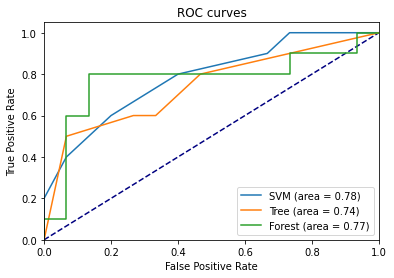

In [33]:
Y_score = clf_svm.decision_function(X_test)

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.plot(fpr, tpr, label="SVM (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Y_score = clf_tree.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="Tree (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

Y_score = clf_forest.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(Y_test, Y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label="Forest (area = %0.2f)" % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.title('ROC curves')

plt.show()

On observ alors que l'optimisation des hyper-paramètres a permis d'améliorer le score `roc_auc` pour lres trois modèles considerés. Cette amélioration est particulièrement notable pour les modèles SVM et arbre de décision. On obtient alors des scores aux alentours de 0.75 pour les 3 modèles, aucun ne s'est clairement demarqué des autres. Ces scores sont satisfaisants mais pour les améliorer on pourait par exemple continuer l'optimisation des paramètres avec des choix plus nombreux et précis des paramètres.